In [1]:
import os
import tensorflow as tf

num_threads = 40
os.environ["OMP_NUM_THREADS"] = "10"
os.environ["TF_NUM_INTRAOP_THREADS"] = "10"
os.environ["TF_NUM_INTEROP_THREADS"] = "10"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)


In [14]:

from tensorflow import keras
from tensorflow.keras import models, layers
import uproot
import numpy as np
import pandas as pd

NUMEPOCHS = 5
PHASEMAX = 100
PERCENTPILEUP = 0.5
NUMTRAINING = 20000
ModelOutputName = 'phaseOnly_5e_testing'
AUGMENTATION = 8
TRACELENGTH = 250
BATCHSIZE = 256


In [3]:
def GetData(filename, treename="timing"):
    '''
    Returns TFile as a pandas dataframe
    '''
    file = uproot.open(filename)
    tree = file[treename]
    npdf = tree.arrays(library="np")
    df =  pd.DataFrame(npdf, columns=npdf.keys())
    return df

def plot_history(history):
    '''
    Plot training and validation loss and accuracy for task 1-3
    '''
    
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot training and validation loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_yscale('log')
    axs[0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['train', 'val'], loc='best')

    plt.savefig('models/'+ModelOutputName+'/history.png')


def GetTraces(values,traceLength=300):
    traces = np.zeros((values.shape[0], traceLength))
    for i in range(values.shape[0]):
        trace = np.array(values[i]).reshape(traceLength, 1)
        traces[i][:] = trace[:, 0]
    return traces


def OneHotEncodePileup(pileup):
    pileup_one_hot = np.zeros((pileup.shape[0], 2))
    for i in range(pileup.shape[0]):
        if pileup[i]:
            pileup_one_hot[i][:] = [1, 0]
        else:
            pileup_one_hot[i][:] = [0, 1]
    return pileup_one_hot

def GetPhases(phases):
    phase = np.zeros((phases.shape[0], 1))
    for i in range(phases.shape[0]):
        if phases[i] > 0:
            phase[i] = phases[i]
        else:
            phase[i] = 0.0
    return phase
    
def NormalizeTraces(traces):
    for i in range(len(traces)):
        baseline = np.average(traces[i][0:40])
        traces[i] -= baseline
        tmax = np.amax(traces[i])
        traces[i] /= tmax
    return traces

def PhaseNet():
    defSize = TRACELENGTH-4*AUGMENTATION
    input = layers.Input(shape=(defSize,1))
    conv1 = layers.Conv1D(kernel_size=10, filters=64, activation='tanh')(input)
    max1 = layers.MaxPooling1D(pool_size=1)(conv1)
    conv3 = layers.Conv1D(kernel_size=1, filters=64, activation='relu')(max1)
    max3 = layers.MaxPooling1D(pool_size=1)(conv3)
    conv4 = layers.Conv1D(kernel_size=2, filters=64, activation='relu', padding='same')(max3)
    max4 = layers.MaxPooling1D(pool_size=10)(conv4)
    
    flat1 = layers.Flatten()(max4)
    dense2 = layers.Dense(128, activation='relu')(flat1)
    output = layers.Dense(1, activation='linear')(dense2)
    
    model = models.Model(inputs=input, outputs=output)
    model.summary()
    
    return model

def getRandomPileupTraces(tt1,tt2,rndphase,scale):
  newtot = np.zeros_like(tt1)
  newtt1 = np.zeros_like(tt1)
  newtt2 = np.zeros_like(tt2)
  std2 = np.std(tt2[:60]) # gets deviation for baseline
  for i in range(len(tt1)):
    newtt1[i] = tt1[i]
    if(i<rndphase):
      newtot[i] = tt1[i] + np.random.normal(0,std2)
      newtt2[i] = np.random.normal(0,std2) # gaussian random for baseline
    else:
      i2 = int(i-rndphase)
      newtt2[i] = (tt2[i2+1]-tt2[i2])*(rndphase-int(rndphase))+tt2[i2]
      newtt2[i] *= scale
      newtot[i] = tt1[i] + newtt2[i] + np.random.normal(0,std2)
  max = np.max(newtot)
  nmin = np.min(newtot)
  min = newtt2[-1] if newtt1[-1]>newtt2[-1] else  newtt1[-1] #normalizes bottom
  scale = max-nmin
  # print(max,nmin,min,scale)
  return (newtot)/max,newtt1/max,newtt2/max

def addNoise(dataset,numAugs,labels=None,otherdata=None):
  newData = []
  newLabels = []
  newOther = []
  std2 = 0.01
  for iter in range(len(dataset)):
    for i in range(numAugs):
      newData.append(dataset[iter]+np.random.normal(len(dataset[iter]),i*std2))
      newLabels.append(labels[iter])
      newOther.append(otherdata[iter])
  newData = np.array(newData)
  newLabels = np.array(newLabels)
  newOther = np.array(newOther)
  return newData, newLabels, newOther

def augmentTraces(dataset,numAugs,labels=None,otherdata=None):
  newData = []
  newLabels = []
  newOther = []
  for iter in range(len(dataset)):
    for i in range(numAugs):
      newData.append(dataset[iter][4*i:-4*numAugs+4*i])
      newLabels.append(labels[iter])
      newOther.append(otherdata[iter])
  newData = np.array(newData)
  newLabels = np.array(newLabels)
  newOther = np.array(newOther)
  return newData, newLabels, newOther

def augmentDepiled(dataset,numAugs):
  newData = []
  for iter in range(len(dataset)):
    for i in range(numAugs):
      t1 = dataset[iter][0][4*i:-4*numAugs+4*i]
      t2 = dataset[iter][1][4*i:-4*numAugs+4*i]
      hold = []
      hold.append(t1)
      hold.append(t2)
      newData.append(hold)
  newData = np.array(newData)
  return newData

def createPileup(pdf):
    traces = GetTraces(pdf["trace"].values)

    traces_no_pileup = traces
    rand_phase_shifts = np.random.uniform(0.1, PHASEMAX, traces_no_pileup.shape[0])
    rand_amplitude_shifts = np.random.uniform(0.5, 1.5, traces_no_pileup.shape[0])
    rand_ifPile = np.random.uniform(0, 1, traces_no_pileup.shape[0])

    phases = np.zeros((traces_no_pileup.shape[0], 1))
    amps = np.zeros((traces_no_pileup.shape[0], 1))
    ifPile = np.zeros((traces_no_pileup.shape[0], 1))
    traces_depiled = np.zeros((traces_no_pileup.shape[0], 2, TRACELENGTH))
    traces_piledup = np.zeros((traces_no_pileup.shape[0], TRACELENGTH,1))

    for i in range(traces_no_pileup.shape[0]):
        if rand_ifPile[i]<PERCENTPILEUP:
            rand_trace = int(np.random.uniform(0,traces_no_pileup.shape[0]))
            traces_piledup[i][:,0],traces_depiled[i][0][:],traces_depiled[i][1][:] = getRandomPileupTraces(traces_no_pileup[i][:TRACELENGTH],traces_no_pileup[rand_trace][:TRACELENGTH],rand_phase_shifts[i],rand_amplitude_shifts[i])
            phases = rand_phase_shifts[i]
            amps = rand_amplitude_shifts[i]
            ifPile[i] = 1
        else:
            traces_piledup[i][:,0] = traces_no_pileup[i][:TRACELENGTH]
            traces_depiled[i][0][:] = traces_no_pileup[i][:TRACELENGTH]
            traces_depiled[i][1][:] = np.zeros_like(traces_no_pileup[i][:TRACELENGTH])
            phases = 0.
            amps = 0.
    return traces_piledup, phases, amps, ifPile

## Use for creating new data set

In [4]:
# pdf = GetData("ysoTracesNoPileup.root")
# pdf = pdf[pdf["trace"].apply(lambda x: x.shape[0] == 300)].reset_index(drop=True)
# #pile_up_one_hot = OneHotEncodePileup(pdf["pileup"].values)
# phase_shifts = GetPhases(pdf["phase"].values)
# traces = GetTraces(pdf["trace"].values)
# print('Loaded Data')


# traces_no_pileup = pdf["trace"].values[pdf["pileup"].values == False]
# rand_phase_shifts = np.random.uniform(0.1, PHASEMAX, traces_no_pileup.shape[0])
# rand_amplitude_shifts = np.random.uniform(0.5, 1.5, traces_no_pileup.shape[0])
# rand_ifPile = np.random.uniform(0, 1, traces_no_pileup.shape[0])

# phase_amplitude = np.zeros((traces_no_pileup.shape[0], 2))
# traces_depiled = np.zeros((traces_no_pileup.shape[0], 2, 300))
# traces_piledup = np.zeros((traces_no_pileup.shape[0], 300,1))

# for i in range(traces_no_pileup.shape[0]):
#     if rand_ifPile[i]<PERCENTPILEUP:
#         rand_trace = int(np.random.uniform(0,traces_no_pileup.shape[0]))
#         traces_piledup[i][:,0],traces_depiled[i][0][:],traces_depiled[i][1][:] = getRandomPileupTraces(traces_no_pileup[i][:300],traces_no_pileup[rand_trace][:300],rand_phase_shifts[i],rand_amplitude_shifts[i])
#         phase_amplitude[i][0] = rand_phase_shifts[i]
#         phase_amplitude[i][1] = rand_amplitude_shifts[i]
#     else:
#         traces_piledup[i][:,0] = traces_no_pileup[i][:300]
#         traces_depiled[i][0][:] = traces_no_pileup[i][:300]
#         traces_depiled[i][1][:] = np.zeros_like(traces_no_pileup[i][:300])
#         phase_amplitude[i][0] = 0.
#         phase_amplitude[i][1] = 0.

# pile_up_one_hot = OneHotEncodePileup(rand_ifPile)

# print('Formatted Data')
# traces_piledup,phase_amplitude = augmentTraces(traces_piledup,AUGMENTATION,phase_amplitude)
# print('Augmented Traces')
# traces_depiled = augmentDepiled(traces_depiled,AUGMENTATION)
# print('Augmented Depiled')

## Use Pileup Dataset from signal splitting

In [4]:
import re
from itertools import chain
dir = 'data/lyso950V/'
files = ['pileup10600ps.root','pileup11760ps.root','pileup1326ps.root','pileup18350ps.root','pileup20840ps.root','pileup2125ps.root','pileup23180ps.root','pileup27700ps.root','pileup36700ps.root','pileup3735ps.root','pileup46100ps.root','pileup55300ps.root','pileup9246ps.root','pileup9660ps.root','pileup0.root','pileup0Oscilloscope.root','pileup0Pixie.root']
dir2 = 'data/lyso1100V/'
files2 = ['newPileup1270ps.root','newPileup13000ps.root','newPileup14100ps.root','newPileup18400ps.root','newPileup19000ps.root','newPileup2490ps.root','newPileup27700ps.root','newPileup32600ps.root','newPileup3740ps.root','newPileup46200ps.root','newPileup4880ps.root','newPileup9280ps.root','newPileup9660ps.root','newPileup0.root','newPileup0Oscilloscope.root','newPileup0Pixie.root']
zeroFiles = ['pileup0.root','pileup0Oscilloscope.root','pileup0Pixie.root','newPileup0.root','newPileup0Oscilloscope.root','newPileup0Pixie.root']
traces = []
phases = []
ifPile = []
qdcs = []
amps = []
for f in files:
    fname = dir+f
    tree = 'data'
    traceBranch = "traceone"
    traceLength = 250
    phase = float(re.sub('\D','',f))/1000
    print(phase)
    pdf = GetData(fname,tree)
    pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)
    # pdf = pdf[pdf["qdcone"].apply(lambda x: x > 100000 and x<250000)].reset_index(drop=True)
    # # pile_up_one_hot = OneHotEndocePileup(pdf["pileup"].values)
    qdcs.append(GetPhases(pdf["qdcone"].values))
    tt = GetTraces(pdf[traceBranch].values,traceLength)
    traces.append(tt)
    phases.append(np.full((len(tt),1),phase))
    ifPile.append(np.full((len(tt),1),phase>0))
    amps.append(np.full((len(tt),1),phase>0).astype(np.float))

for f in files2:
    fname = dir2+f
    tree = 'data'
    traceBranch = "traceone"
    traceLength = 250
    phase = float(re.sub('\D','',f))/1000
    print(phase)
    pdf = GetData(fname,tree)
    pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)
    # pdf = pdf[pdf["qdcone"].apply(lambda x: x > 100000 and x<250000)].reset_index(drop=True)
    # # pile_up_one_hot = OneHotEndocePileup(pdf["pileup"].values)
    qdcs.append(GetPhases(pdf["qdcone"].values))
    tt = GetTraces(pdf[traceBranch].values,traceLength)
    traces.append(tt)
    phases.append(np.full((len(tt),1),phase))
    ifPile.append(np.full((len(tt),1),phase>0))
    amps.append(np.full((len(tt),1),phase>0).astype(np.float))

for i in range(len(zeroFiles)):
    f = zeroFiles[i]
    d = dir if i<3 else dir2
    fname = d+f
    tree = 'data'
    traceBranch = "traceone"
    traceLength = 250
    phase = float(re.sub('\D','',f))/1000
    print(phase)
    pdf = GetData(fname,tree)
    pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)
    
    traces_no_pileup = GetTraces(pdf[traceBranch].values,traceLength)
    rand_phase_shifts = np.random.uniform(0.1, PHASEMAX, traces_no_pileup.shape[0])
    rand_amplitude_shifts = np.random.uniform(0.5, 1.5, traces_no_pileup.shape[0])
    rand_ifPile = np.random.uniform(0, 1, traces_no_pileup.shape[0])

    pp = np.zeros((traces_no_pileup.shape[0], 1))
    aa = np.zeros((traces_no_pileup.shape[0], 1))
    ip = np.zeros((traces_no_pileup.shape[0], 1))
    traces_depiled = np.zeros((traces_no_pileup.shape[0], 2, TRACELENGTH))
    traces_piledup = np.zeros((traces_no_pileup.shape[0], TRACELENGTH))

    for i in range(traces_no_pileup.shape[0]):
        if rand_ifPile[i]<PERCENTPILEUP:
            rand_trace = int(np.random.uniform(0,traces_no_pileup.shape[0]))
            traces_piledup[i],traces_depiled[i][0][:],traces_depiled[i][1][:] = getRandomPileupTraces(traces_no_pileup[i][:TRACELENGTH],traces_no_pileup[rand_trace][:TRACELENGTH],rand_phase_shifts[i],rand_amplitude_shifts[i])
            pp[i] = 2*rand_phase_shifts[i]
            aa[i] = rand_amplitude_shifts[i]
            ip[i] = 1
        else:
            traces_piledup[i] = traces_no_pileup[i][:TRACELENGTH]
            traces_depiled[i][0][:] = traces_no_pileup[i][:TRACELENGTH]
            traces_depiled[i][1][:] = np.zeros_like(traces_no_pileup[i][:TRACELENGTH])
            pp[i] = 0.
            aa[i] = 0.
    traces.append(traces_piledup)
    phases.append(pp)
    amps.append(aa)
    qdcs.append(GetPhases(pdf["qdcone"].values))
    ifPile.append(ip)


traces = list(chain.from_iterable(traces))
phases = list(chain.from_iterable(phases))
ifPile = list(chain.from_iterable(ifPile))
qdcs = list(chain.from_iterable(qdcs))
amps = list(chain.from_iterable(amps))
traces = NormalizeTraces(np.array(traces))
phases = np.array(phases)
ifPile = np.array(ifPile)
qdcs = np.array(qdcs)
# amps = ifPile.astype(np.float)
print('Formatted Data')
traces,phases,qdcs = augmentTraces(traces,AUGMENTATION,phases,qdcs)
traces,phases,qdcs = addNoise(traces,3,phases,qdcs)
print('Loaded Data')

10.6
11.76
1.326
18.35
20.84
2.125
23.18
27.7
36.7
3.735
46.1
55.3
9.246
9.66
0.0
0.0
0.0
1.27
13.0
14.1
18.4
19.0
2.49
27.7
32.6
3.74
46.2
4.88
9.28
9.66
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Formatted Data
Loaded Data


In [8]:
print(traces.shape, phases.shape, qdcs.shape)

(9826776, 218) (9826776, 1) (9826776, 1)


In [22]:
model = PhaseNet()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 218, 1)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 209, 64)           704       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 209, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 209, 64)           4160      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 209, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 209, 64)           8256      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 20, 64)            0   

In [27]:
checkpoint_path = "models/"+ModelOutputName+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [11]:
from sklearn.model_selection import train_test_split
# train_x = traces_piledup[:NUMTRAINING]
# train_y = phase_amplitude[:NUMTRAINING,0]
train_x, test_x, train_y, test_y, train_q, test_q = train_test_split(traces,phases,qdcs,test_size=0.5)


In [28]:
model.save_weights(checkpoint_path.format(epoch=0))
history = model.fit(train_x, train_y, epochs=NUMEPOCHS, batch_size=BATCHSIZE, validation_split=0.2, verbose=2,callbacks=[cp_callback])

Epoch 1/5
15355/15355 - 484s - loss: 990.7975 - accuracy: 0.0000e+00 - val_loss: 989.3972 - val_accuracy: 0.0000e+00

Epoch 00001: saving model to models/phaseOnly_5e_testing/cp-0001.ckpt
Epoch 2/5
15355/15355 - 491s - loss: 990.7228 - accuracy: 0.0000e+00 - val_loss: 988.8789 - val_accuracy: 0.0000e+00

Epoch 00002: saving model to models/phaseOnly_5e_testing/cp-0002.ckpt
Epoch 3/5


KeyboardInterrupt: 

INFO:tensorflow:Assets written to: models/phaseOnly_300e_moreData/assets


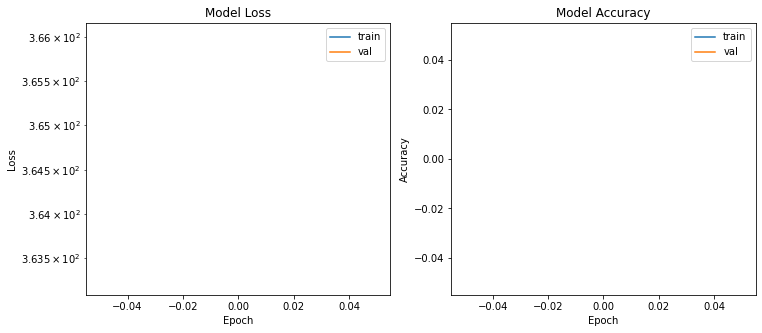

In [13]:
os.listdir(checkpoint_dir)
 #### Saving the model 
model.save('models/'+ModelOutputName)
plot_history(history)

In [40]:
from sklearn.metrics import roc_curve
# test_x = traces_piledup[NUMTRAINING:NUMTRAINING+10000]
# # test_y = pile_up_one_hot[NUMTRAINING:NUMTRAINING+10000]
# test_p = phase_amplitude[NUMTRAINING:NUMTRAINING+10000,0]
# test_a = phase_amplitude[NUMTRAINING:NUMTRAINING+10000,1]
# test_x = traces[NUMTRAINING:NUMTRAINING+10000]
test_p = test_y[NUMTRAINING:NUMTRAINING+10000]
test_a = test_q[NUMTRAINING:NUMTRAINING+10000]
test_y_hat = model.predict(test_x[NUMTRAINING:NUMTRAINING+10000])
pres = []
truePos = []
falsePos = []
test_if = test_p.astype(bool)
test_if_hat = test_y_hat.astype(bool)
acc = 0
correct = []
for i in range(len(test_y_hat)):
  pres.append(test_y_hat[i]-test_p[i])
  acc += test_if[i]==test_if_hat[i]
  correct.append(test_if[i]==test_if_hat[i])
acc = acc/(len(test_if))
pres = np.array(pres)
correct = np.array(correct).astype(float)

In [44]:
print(test_p.shape,correct.shape)

(10000, 1) (10000, 1)


(array([[2.272e+03, 6.000e+00],
        [0.000e+00, 5.240e+02],
        [0.000e+00, 5.030e+02],
        [0.000e+00, 5.470e+02],
        [0.000e+00, 2.520e+02],
        [0.000e+00, 9.000e+00],
        [0.000e+00, 6.000e+00],
        [0.000e+00, 6.000e+00],
        [0.000e+00, 7.000e+00],
        [0.000e+00, 1.097e+03],
        [0.000e+00, 2.380e+02],
        [0.000e+00, 2.490e+02],
        [0.000e+00, 1.200e+01],
        [0.000e+00, 2.720e+02],
        [0.000e+00, 2.650e+02],
        [0.000e+00, 7.000e+00],
        [0.000e+00, 4.000e+00],
        [0.000e+00, 9.000e+00],
        [0.000e+00, 5.720e+02],
        [0.000e+00, 2.800e+02],
        [0.000e+00, 2.380e+02],
        [0.000e+00, 8.000e+00],
        [0.000e+00, 7.000e+00],
        [0.000e+00, 2.160e+02],
        [0.000e+00, 1.000e+01],
        [0.000e+00, 5.000e+00],
        [0.000e+00, 5.000e+00],
        [0.000e+00, 5.220e+02],
        [0.000e+00, 5.000e+00],
        [0.000e+00, 9.000e+00],
        [0.000e+00, 1.400e+01],
        

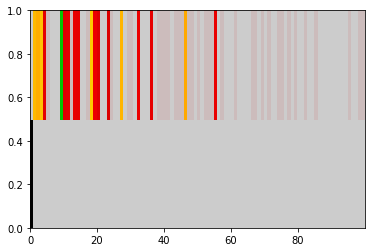

In [48]:
plt.hist2d(test_p[:,0],correct[:,0],bins=(100,2),cmap='nipy_spectral_r')

Text(0.5, 0, 'Residual [ns]')

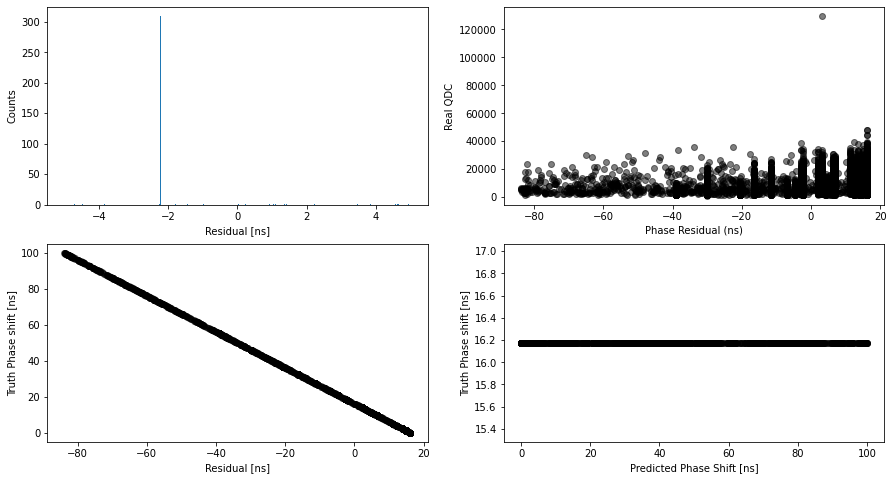

In [16]:
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(2, 2 ,figsize=(15, 8))
# n = np.random.randint(0, test_x.shape[0])

# ax[0][0].hist2d(test_y[:,1],test_y_hat[:,1],bins=2)
# ax[0][0].set_xlabel("Real Pileup")
# ax[0][0].set_ylabel("Predicted Pileup")

ax[0][1].plot(pres,test_a, 'o', color='black',alpha=0.5)
# ax[0][1].set_xlim(-5,5)
ax[0][1].set_ylabel("Real QDC")
ax[0][1].set_xlabel("Phase Residual (ns)")

ax[1][1].plot(test_p,test_y_hat, 'o', color='black',alpha=0.5)
ax[1][1].set_ylabel("Truth Phase shift [ns]")
ax[1][1].set_xlabel("Predicted Phase Shift [ns]")

ax[0][0].hist(pres,bins=1000,range=(-5,5))
ax[0][0].set_xlabel("Residual [ns]")
ax[0][0].set_ylabel("Counts")

ax[1][0].plot(pres,test_p, 'o', color='black',alpha=0.5)
# ax[1][0].set_xlim(-5,5)
ax[1][0].set_ylabel("Truth Phase shift [ns]")
ax[1][0].set_xlabel("Residual [ns]")